## import packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import catboost as cbt
import xgboost as xgb
import lightgbm as lgb
import sklearn
import pandas_profiling
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import roc_auc_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
import warnings

warnings.filterwarnings('ignore')

sns.set()
%matplotlib inline
pd.set_option('display.max_columns', None)

## 1. import data

In [76]:
train = pd.read_csv('train.csv')
test = pd.read_csv('testB.csv')
test['isDefault'] = -999
data = pd.concat([train, test])
train.shape, test.shape

((800000, 47), (200000, 47))

## 2. EDA

In [77]:
train.head()

,id,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,annualIncome,verificationStatus,issueDate,isDefault,purpose,postCode,regionCode,dti,delinquency_2years,ficoRangeLow,ficoRangeHigh,openAcc,pubRec,pubRecBankruptcies,revolBal,revolUtil,totalAcc,initialListStatus,applicationType,earliesCreditLine,title,policyCode,n0,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14
0,0,35000.0,5,19.52,917.97,E,E2,320.0,2 years,2,110000.0,2,2014-07-01,1,1,137.0,32,17.05,0.0,730.0,734.0,7.0,0.0,0.0,24178.0,48.9,27.0,0,0,Aug-2001,1.0,1.0,0.0,2.0,2.0,2.0,4.0,9.0,8.0,4.0,12.0,2.0,7.0,0.0,0.0,0.0,2.0
1,1,18000.0,5,18.49,461.90,D,D2,219843.0,5 years,0,46000.0,2,2012-08-01,0,0,156.0,18,27.83,0.0,700.0,704.0,13.0,0.0,0.0,15096.0,38.9,18.0,1,0,May-2002,1723.0,1.0,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN
2,2,12000.0,5,16.99,298.17,D,D3,31698.0,8 years,0,74000.0,2,2015-10-01,0,0,337.0,14,22.77,0.0,675.0,679.0,11.0,0.0,0.0,4606.0,51.8,27.0,0,0,May-2006,0.0,1.0,0.0,0.0,3.0,3.0,0.0,0.0,21.0,4.0,5.0,3.0,11.0,0.0,0.0,0.0,4.0
3,3,11000.0,3,7.26,340.96,A,A4,46854.0,10+ years,1,118000.0,1,2015-08-01,0,4,148.0,11,17.21,0.0,685.0,689.0,9.0,0.0,0.0,9948.0,52.6,28.0,1,0,May-1999,4.0,1.0,6.0,4.0,6.0,6.0,4.0,16.0,4.0,7.0,21.0,6.0,9.0,0.0,0.0,0.0,1.0
4,4,3000.0,3,12.99,101.07,C,C2,54.0,NaN,1,29000.0,2,2016-03-01,0,10,301.0,21,32.16,0.0,690.0,694.0,12.0,0.0,0.0,2942.0,32.0,27.0,0,0,Aug-1977,11.0,1.0,1.0,2.0,7.0,7.0,2.0,4.0,9.0,10.0,15.0,7.0,12.0,0.0,0.0,0.0,4.0


In [78]:
train.describe()

,id,loanAmnt,term,interestRate,installment,employmentTitle,homeOwnership,annualIncome,verificationStatus,isDefault,purpose,postCode,regionCode,dti,delinquency_2years,ficoRangeLow,ficoRangeHigh,openAcc,pubRec,pubRecBankruptcies,revolBal,revolUtil,totalAcc,initialListStatus,applicationType,title,policyCode,n0,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14
count,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,799999.000000,800000.000000,8.000000e+05,800000.000000,800000.000000,800000.000000,799999.000000,800000.000000,799761.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,799595.000000,8.000000e+05,799469.000000,800000.000000,800000.000000,800000.000000,799999.000000,800000.0,759730.000000,759730.000000,759730.000000,759730.000000,766761.000000,759730.000000,759730.000000,759730.000000,759729.000000,759730.000000,766761.000000,730248.000000,759730.000000,759730.000000,759730.000000
mean,399999.500000,14416.818875,3.482745,13.238391,437.947723,72005.351714,0.614213,7.613391e+04,1.009683,0.199513,1.745982,258.535648,16.385758,18.284557,0.318239,696.204081,700.204226,11.598020,0.214915,0.134163,1.622871e+04,51.790734,24.998861,0.416953,0.019267,1754.113589,1.0,0.511932,3.642330,5.642648,5.642648,4.735641,8.107937,8.575994,8.282953,14.622488,5.592345,11.643896,0.000815,0.003384,0.089366,2.178606
std,230940.252013,8716.086178,0.855832,4.765757,261.460393,106585.640204,0.675749,6.894751e+04,0.782716,0.399634,2.367453,200.037446,11.036679,11.150155,0.880325,31.865995,31.866674,5.475286,0.606467,0.377471,2.245802e+04,24.516126,11.999201,0.493055,0.137464,7941.474040,0.0,1.333266,2.246825,3.302810,3.302810,2.949969,4.799210,7.400536,4.561689,8.124610,3.216184,5.484104,0.030075,0.062041,0.509069,1.844377
min,0.000000,500.000000,3.000000,5.310000,15.690000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,630.000000,634.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,2.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,199999.750000,8000.000000,3.000000,9.750000,248.450000,427.000000,0.000000,4.560000e+04,0.000000,0.000000,0.000000,103.000000,8.000000,11.790000,0.000000,670.000000,674.000000,8.000000,0.000000,0.000000,5.944000e+03,33.400000,16.000000,0.000000,0.000000,0.000000,1.0,0.000000,2.000000,3.000000,3.000000,3.000000,5.000000,4.000000,5.000000,9.000000,3.000000,8.000000,0.000000,0.000000,0.000000,1.000000
50%,399999.500000,12000.000000,3.000000,12.740000,375.135000,7755.000000,1.000000,6.500000e+04,1.000000,0.000000,0.000000,203.000000,14.000000,17.610000,0.000000,690.000000,694.000000,11.000000,0.000000,0.000000,1.113200e+04,52.100000,23.000000,0.000000,0.000000,1.000000,1.0,0.000000,3.000000,5.000000,5.000000,4.000000,7.000000,7.000000,7.000000,13.000000,5.000000,11.000000,0.000000,0.000000,0.000000,2.000000
75%,599999.250000,20000.000000,3.000000,15.990000,580.710000,117663.500000,1.000000,9.000000e+04,2.000000,0.000000,4.000000,395.000000,22.000000,24.060000,0.000000,710.000000,714.000000,14.000000,0.000000,0.000000,1.973400e+04,70.700000,32.000000,1.000000,0.000000,5.000000,1.0,0.000000,5.000000,7.000000,7.000000,6.000000,11.000000,11.000000,10.000000,19.000000,7.000000,14.000000,0.000000,0.000000,0.000000,3.000000
max,799999.000000,40000.000000,5.000000,30.990000,1715.420000,378351.000000,5.000000,1.099920e+07,2.000000,1.000000,13.000000,940.000000,50.000000,999.000000,39.000000,845.000000,850.000000,86.000000,86.000000,12.000000,2.904836e+06,892.300000,162.000000,1.000000,1.000000,61680.000000,1.0,51.000000,33.000000,63.000000,63.000000,49.000000,70.000000,132.000000,79.000000,128.000000,45.000000,82.000000,4.000000,4.000000,39.000000,30.000000


In [79]:
test.describe()

,id,loanAmnt,term,interestRate,installment,employmentTitle,homeOwnership,annualIncome,verificationStatus,purpose,postCode,regionCode,dti,delinquency_2years,ficoRangeLow,ficoRangeHigh,openAcc,pubRec,pubRecBankruptcies,revolBal,revolUtil,totalAcc,initialListStatus,applicationType,title,policyCode,n0,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14,isDefault
count,2.000000e+05,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,2.000000e+05,200000.000000,200000.000000,200000.000000,200000.000000,199959.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,199888.000000,2.000000e+05,199873.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.0,189949.000000,189949.000000,189949.000000,189949.000000,191647.000000,189949.000000,189949.000000,189949.000000,189949.000000,189949.000000,191647.000000,182560.000000,189949.000000,189949.000000,189949.000000,200000.0
mean,1.100000e+06,14410.529000,3.482790,13.232435,437.664427,72351.484360,0.613315,7.638478e+04,1.008850,1.750430,257.775865,16.411865,18.261008,0.317625,696.204075,700.204190,11.589245,0.216045,0.134770,1.623094e+04,51.789122,24.980455,0.418010,0.018460,1749.588810,1.0,0.506589,3.638982,5.634581,5.634581,4.734496,8.096521,8.582393,8.272320,14.592975,5.583004,11.635063,0.000838,0.003601,0.087803,2.179575,-999.0
std,5.773517e+04,8709.360103,0.855861,4.774517,260.978300,106772.323713,0.674160,7.119643e+04,0.783323,2.368563,199.982297,11.037711,11.339443,0.874090,31.790024,31.790564,5.476066,0.594543,0.376872,2.153005e+04,24.497254,12.034809,0.493233,0.134608,7906.561324,0.0,1.319058,2.245450,3.292101,3.292101,2.961707,4.816749,7.414746,4.555254,8.117751,3.206025,5.484064,0.032672,0.063898,0.492813,1.852181,0.0
min,1.000000e+06,500.000000,3.000000,5.310000,4.930000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,660.000000,664.000000,1.000000,0.000000,0.000000,0.000000e+00,0.000000,2.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-999.0
25%,1.050000e+06,7950.000000,3.000000,9.750000,248.010000,427.000000,0.000000,4.600000e+04,0.000000,0.000000,101.000000,8.000000,11.750000,0.000000,670.000000,674.000000,8.000000,0.000000,0.000000,5.940000e+03,33.400000,16.000000,0.000000,0.000000,0.000000,1.0,0.000000,2.000000,3.000000,3.000000,3.000000,5.000000,4.000000,5.000000,9.000000,3.000000,8.000000,0.000000,0.000000,0.000000,1.000000,-999.0
50%,1.100000e+06,12000.000000,3.000000,12.740000,374.870000,7903.000000,1.000000,6.500000e+04,1.000000,0.000000,201.000000,14.000000,17.600000,0.000000,690.000000,694.000000,11.000000,0.000000,0.000000,1.114000e+04,52.100000,23.000000,0.000000,0.000000,2.000000,1.0,0.000000,3.000000,5.000000,5.000000,4.000000,7.000000,7.000000,7.000000,13.000000,5.000000,11.000000,0.000000,0.000000,0.000000,2.000000,-999.0
75%,1.149999e+06,20000.000000,3.000000,15.990000,580.342500,119373.250000,1.000000,9.000000e+04,2.000000,4.000000,392.000000,22.000000,24.030000,0.000000,710.000000,714.000000,14.000000,0.000000,0.000000,1.976925e+04,70.700000,32.000000,1.000000,0.000000,5.000000,1.0,0.000000,5.000000,7.000000,7.000000,6.000000,11.000000,11.000000,10.000000,19.000000,7.000000,14.000000,0.000000,0.000000,0.000000,3.000000,-999.0
max,1.199999e+06,40000.000000,5.000000,30.990000,1628.080000,378352.000000,5.000000,9.300000e+06,2.000000,13.000000,942.000000,49.000000,999.000000,20.000000,845.000000,850.000000,88.000000,37.000000,8.000000,1.043860e+06,155.300000,173.000000,1.000000,1.000000,61681.000000,1.0,30.000000,35.000000,47.000000,47.000000,57.000000,61.000000,159.000000,63.000000,92.000000,42.000000,87.000000,6.000000,4.000000,16.000000,30.000000,-999.0


In [80]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 47 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  800000 non-null  int64  
 1   loanAmnt            800000 non-null  float64
 2   term                800000 non-null  int64  
 3   interestRate        800000 non-null  float64
 4   installment         800000 non-null  float64
 5   grade               800000 non-null  object 
 6   subGrade            800000 non-null  object 
 7   employmentTitle     799999 non-null  float64
 8   employmentLength    753201 non-null  object 
 9   homeOwnership       800000 non-null  int64  
 10  annualIncome        800000 non-null  float64
 11  verificationStatus  800000 non-null  int64  
 12  issueDate           800000 non-null  object 
 13  isDefault           800000 non-null  int64  
 14  purpose             800000 non-null  int64  
 15  postCode            799999 non-nul

In [81]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 47 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  200000 non-null  int64  
 1   loanAmnt            200000 non-null  float64
 2   term                200000 non-null  int64  
 3   interestRate        200000 non-null  float64
 4   installment         200000 non-null  float64
 5   grade               200000 non-null  object 
 6   subGrade            200000 non-null  object 
 7   employmentTitle     200000 non-null  float64
 8   employmentLength    188492 non-null  object 
 9   homeOwnership       200000 non-null  int64  
 10  annualIncome        200000 non-null  float64
 11  verificationStatus  200000 non-null  int64  
 12  issueDate           200000 non-null  object 
 13  purpose             200000 non-null  int64  
 14  postCode            200000 non-null  float64
 15  regionCode          200000 non-nul

### 2.1 check missing values

In [82]:
missing = pd.DataFrame(train.isnull().sum() / len(train)).reset_index()\
                                    .rename(columns={0: 'pct',
                                                    'index': 'name'})\
                                    .sort_values('pct', ascending=False)
missing[missing.pct>0]

,name,pct
43,n11,0.087190
8,employmentLength,0.058499
40,n8,0.050339
39,n7,0.050338
33,n1,0.050338
34,n2,0.050338
35,n3,0.050338
37,n5,0.050338
38,n6,0.050338
46,n14,0.050338


### 2.2 check default sample distribution

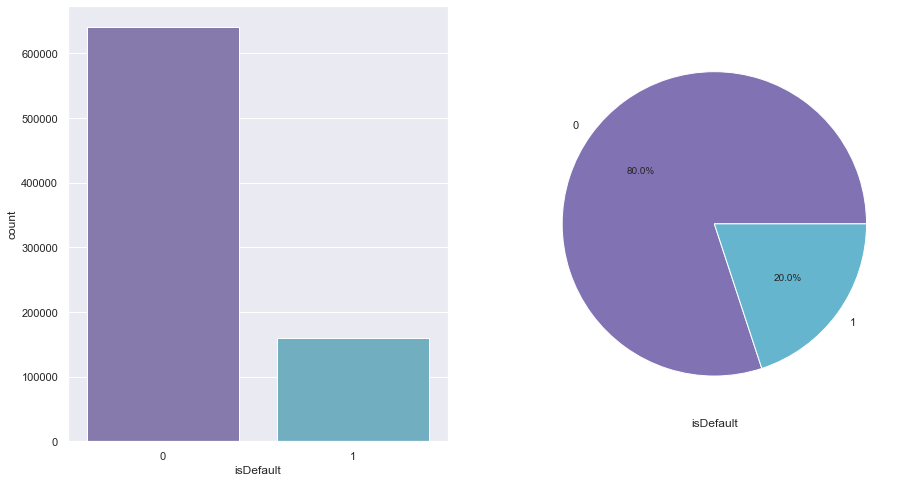

In [83]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
sns.countplot('isDefault', data=train, ax=ax[0], palette=['m', 'c'])
train['isDefault'].value_counts().plot.pie(autopct="%1.1f%%", ax=ax[1], colors=['m', 'c'])
ax[0].set_xlabel('isDefault')
ax[1].set_ylabel('')
ax[1].set_xlabel('isDefault')
plt.show()

From above charts, we know positive samples only accounts for 20% to total samples.

### 2.3 check loanAmnt, term, interestRate

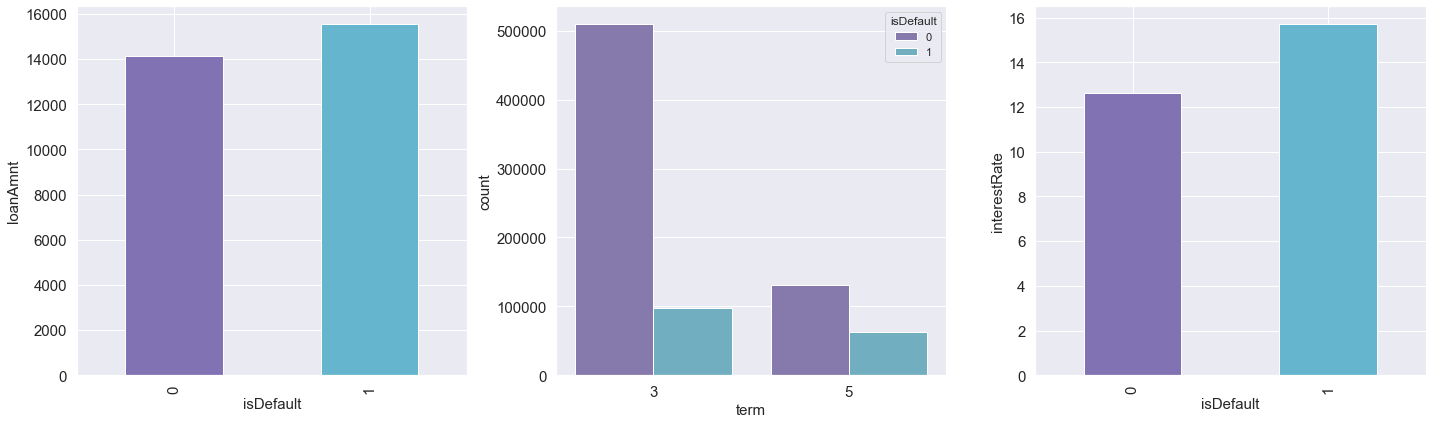

In [84]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
train[['loanAmnt', 'isDefault']].groupby('isDefault')['loanAmnt'].mean().plot.bar(color=['m', 'c'])
plt.ylabel('loanAmnt', fontsize=15)
plt.xlabel('isDefault', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.subplot(1, 3, 2)
sns.countplot('term', hue='isDefault', data=train, palette=['m', 'c'])
plt.ylabel('count', fontsize=15)
plt.xlabel('term', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.subplot(1, 3, 3)
train[['interestRate', 'isDefault']].groupby('isDefault')['interestRate'].mean().plot.bar(color=['m', 'c'])
plt.ylabel('interestRate', fontsize=15)
plt.xlabel('isDefault', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.show()

From above charts:
1. loanAmnt for default group is higher than the otherwise
2. More ppl chose loan term of 3 years and default number of term 3 is higher than term 5.
3. Higher interestRate has higher default

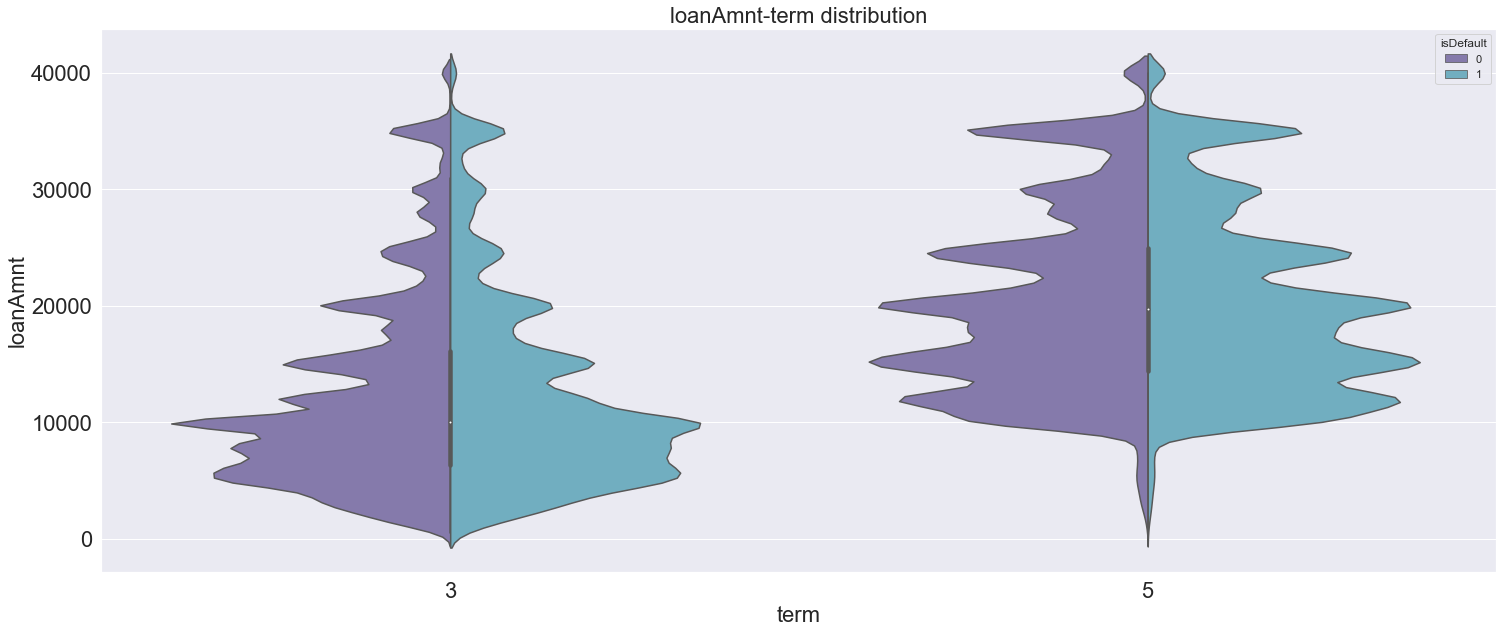

In [85]:
fig = plt.figure(figsize=(25, 10))
sns.violinplot(x='term', y='loanAmnt', hue='isDefault', data=train, split=True, alpha=0.9, palette={0:'m', 1:'c'})
plt.title('loanAmnt-term distribution', fontsize=22)
plt.xlabel('term', fontsize=22)
plt.ylabel('loanAmnt', fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.show()

From above charts:
1. loanAmnt of term 5 is higher than term 3
2. no significant difference between default samples and non-default samples detected

### 2.4 LoanAmnt, grade, subGrade and default

Text(0, 0.5, 'subGrade')

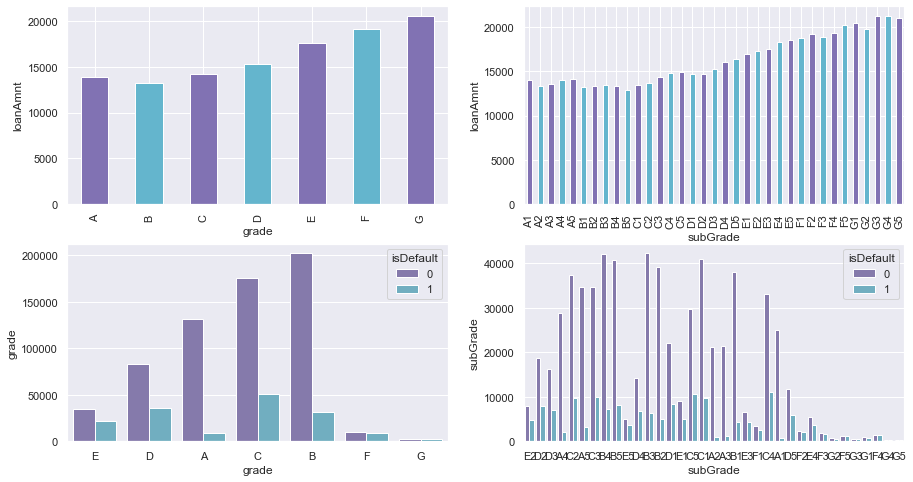

In [86]:
plt.figure(figsize=(15, 8))
plt.subplot(2, 2, 1)
train[['loanAmnt', 'grade']].groupby('grade')['loanAmnt'].mean().plot.bar(color=['m', 'c'])
plt.ylabel('loanAmnt')
plt.subplot(2, 2, 2)
train[['loanAmnt', 'subGrade']].groupby('subGrade')['loanAmnt'].mean().plot.bar(color=['m', 'c'])
plt.ylabel('loanAmnt')
plt.subplot(2, 2, 3)
sns.countplot('grade', hue='isDefault', data=train, palette=['m', 'c'])
plt.ylabel('grade')
plt.subplot(2, 2, 4)
sns.countplot('subGrade', hue='isDefault', data=train, palette=['m', 'c'])
plt.ylabel('subGrade')

From above charts:
1. loanAmnt increases as grade increases, same as subGrade
2. grade B, C, D, E have more default

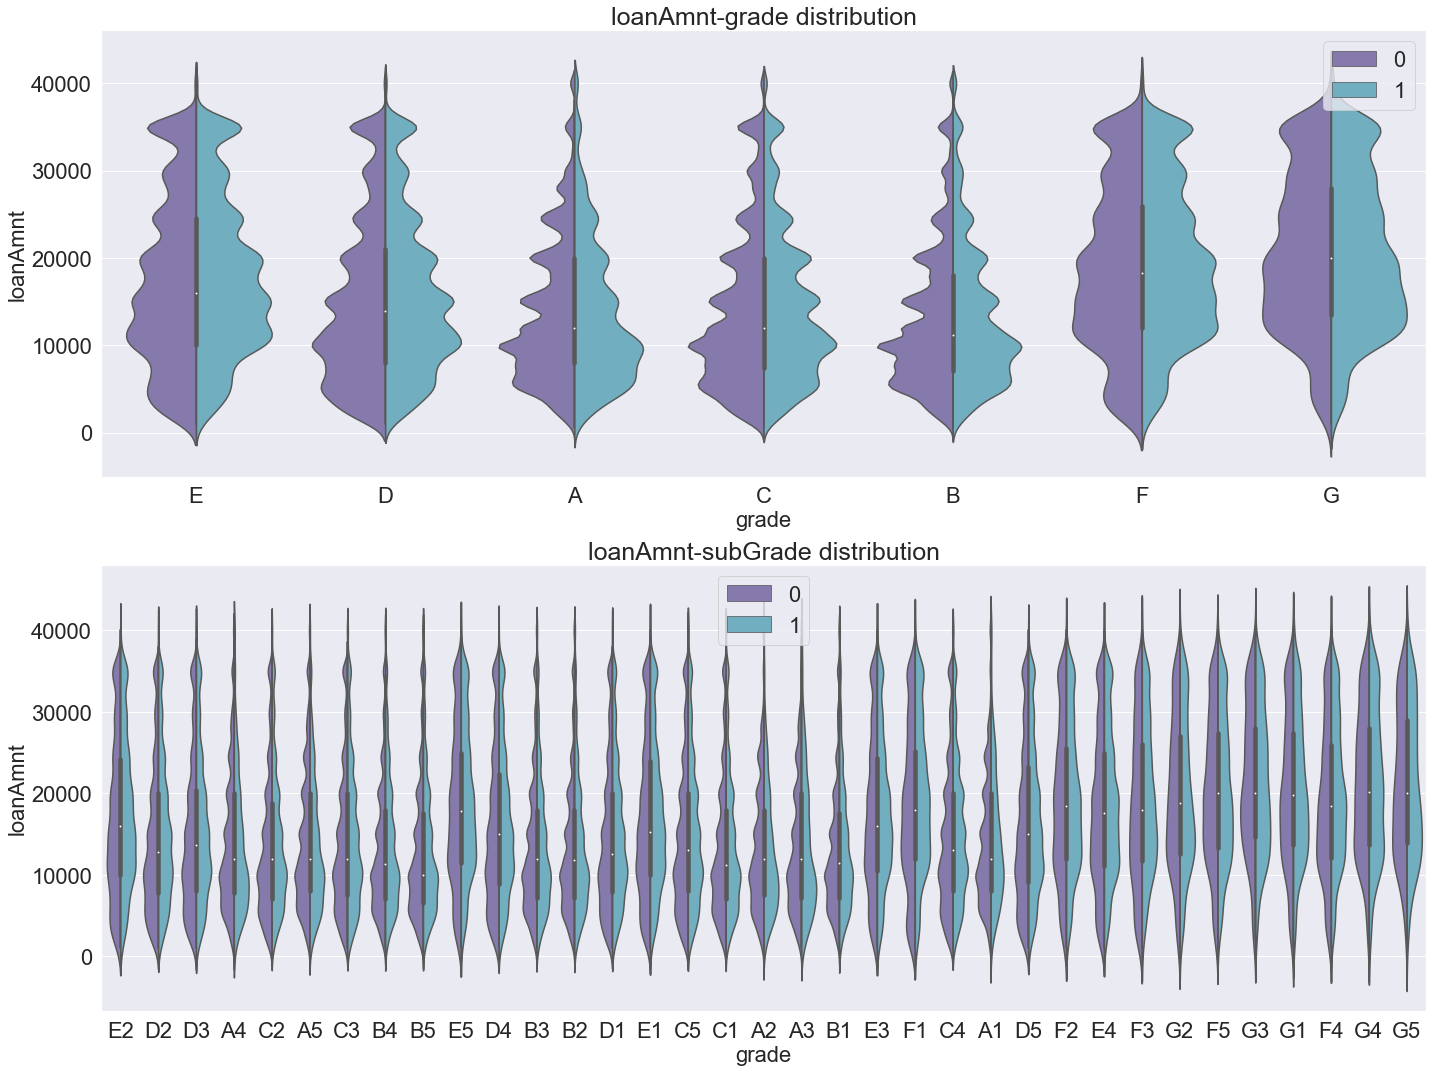

In [87]:
plt.figure(figsize=(20, 15))
plt.subplot(2, 1, 1)
sns.violinplot(x='grade', y='loanAmnt', hue='isDefault', data=train, split=True, alpha=0.9, palette={0:'m', 1: 'c'})
plt.title('loanAmnt-grade distribution', fontsize=25)
plt.xlabel('grade', fontsize=22)
plt.ylabel('loanAmnt', fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.legend(fontsize=22)
plt.subplot(2, 1, 2)
sns.violinplot(x='subGrade', y='loanAmnt', hue='isDefault', data=train, split=True, alpha=0.9,palette={0:'m', 1: 'c'})
plt.title('loanAmnt-subGrade distribution', fontsize=25)
plt.xlabel('grade', fontsize=22)
plt.ylabel('loanAmnt', fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.legend(fontsize=22)
plt.subplot(2, 1, 2)
plt.tight_layout()

From above charts:

default and non-default distribution are similar

### 2.5 annualIncome, employmentLength

<AxesSubplot:xlabel='employmentLength', ylabel='annualIncome'>

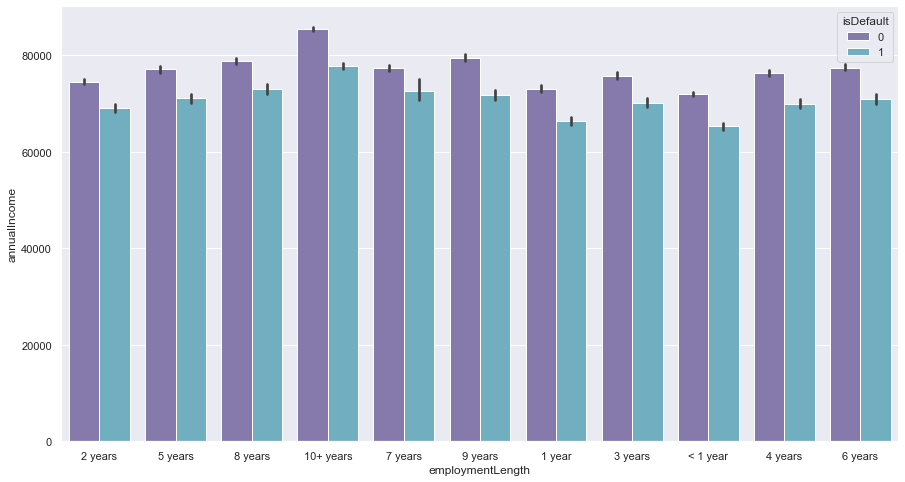

In [88]:
plt.figure(figsize=(15, 8))
ax = plt.subplot()
sns.barplot(x='employmentLength', y='annualIncome', hue='isDefault', data=train, 
            palette=['m', 'c'])

annualIncome seems no significant difference among employmentLength

### 2.6 loanAmnt, dti

Text(0, 0.5, 'dti')

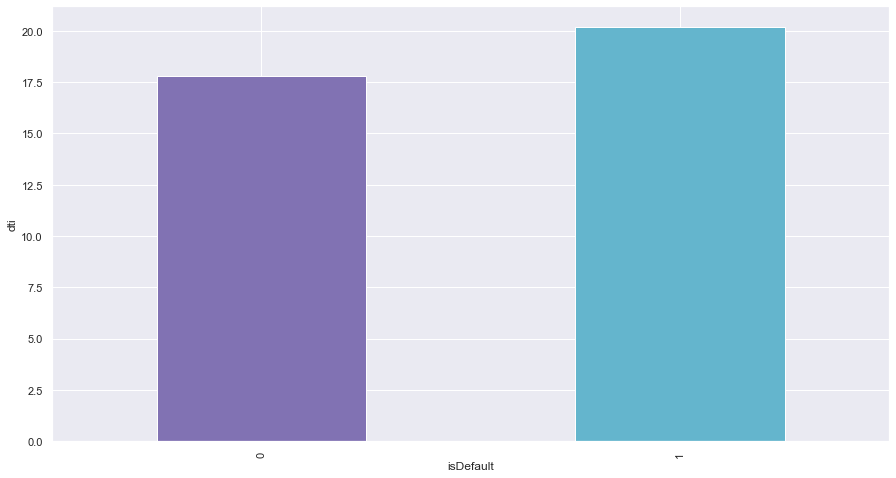

In [89]:
plt.figure(figsize=(15, 8))
train[['dti', 'isDefault']].groupby(['isDefault'])['dti'].mean().plot.bar(color=['m', 'c'])
plt.ylabel('dti')

Higher debt-to-income ratio has higher default which makes sense.

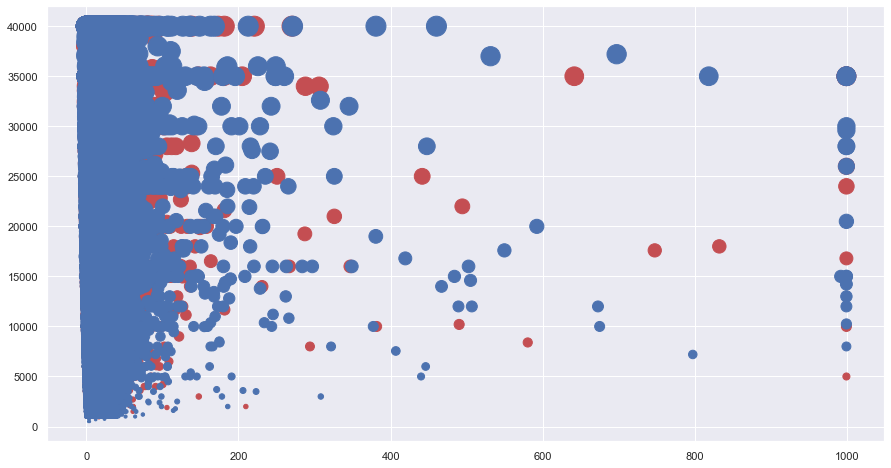

In [90]:
plt.figure(figsize=(15, 8))
ax = plt.subplot()
ax.scatter(train[train['isDefault']==1]['dti'], train[train['isDefault']==1]['loanAmnt'], 
           color='r', s = train[train['isDefault']==1]['loanAmnt']/100)
ax.scatter(train[train['isDefault']==0]['dti'], train[train['isDefault']==0]['loanAmnt'], 
           color='b', s = train[train['isDefault']==0]['loanAmnt']/100)

## 3. Data Cleansing

### 3.1 missing value

In [91]:
missing[missing.pct>0]

,name,pct
43,n11,0.087190
8,employmentLength,0.058499
40,n8,0.050339
39,n7,0.050338
33,n1,0.050338
34,n2,0.050338
35,n3,0.050338
37,n5,0.050338
38,n6,0.050338
46,n14,0.050338


Two strategies:
1. fill in features ['employmentLength', 'pubRecBankruptcies', 'title', 'postCode', 'employmentTitle'] and n0-n14 with mode value
2. fill in features ['dti', 'revolUtil'] with mean value

In [92]:
for fea in ['employmentLength', 'pubRecBankruptcies', 'title', 'postCode', 'employmentTitle'] + \
           ['n'+str(i) for i in range(15)]:
    data[fea] = data[fea].fillna(data[fea].mode()[0])
    
for fea in ['dti', 'revolUtil']:
    data[fea] = data[fea].fillna(data[fea].mean())

### 3.2 Outerliers

<AxesSubplot:>

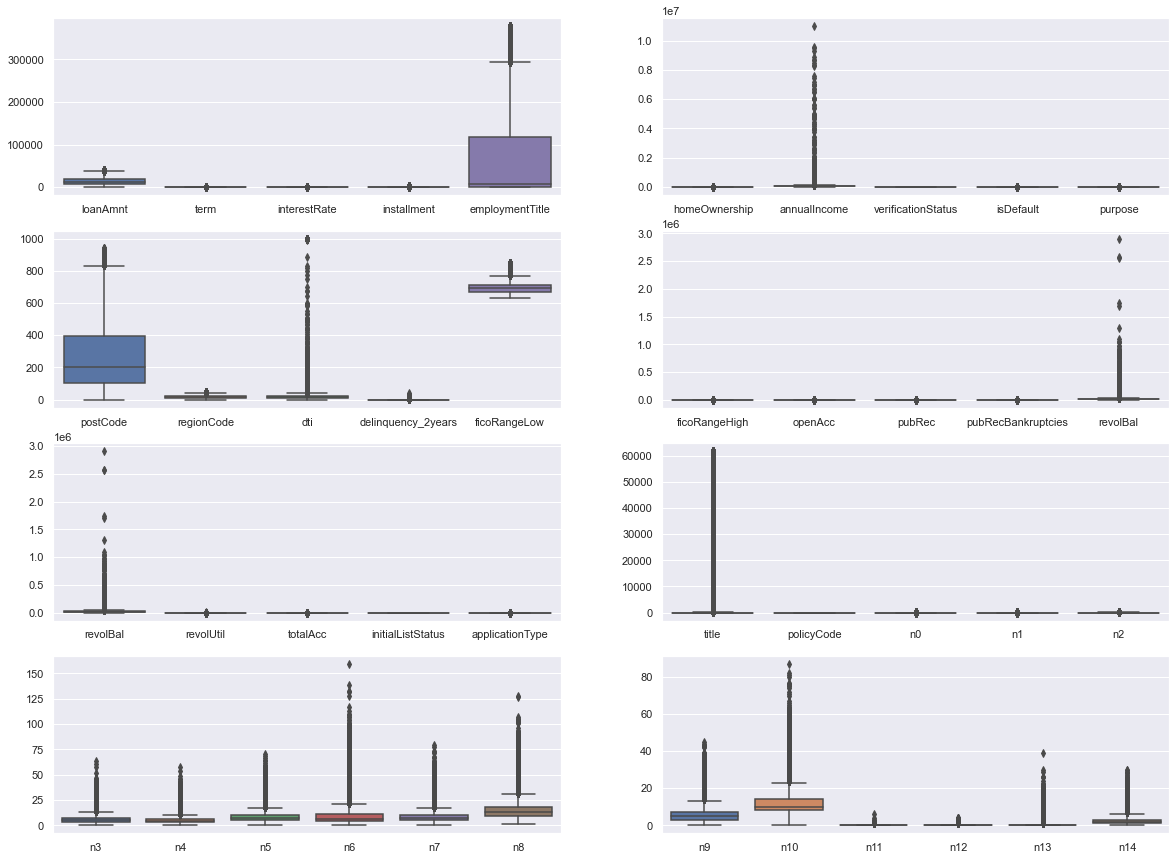

In [93]:
fig, ax = plt.subplots(4, 2, figsize=(20, 15))
sns.boxplot(data=data.iloc[:, 1:8], ax=ax[0][0])
sns.boxplot(data=data.iloc[:, 8:15], ax=ax[0][1])
sns.boxplot(data=data.iloc[:, 15:20], ax=ax[1][0])
sns.boxplot(data=data.iloc[:, 20:25], ax=ax[1][1])
sns.boxplot(data=data.iloc[:, 24:29], ax=ax[2][0])
sns.boxplot(data=data.iloc[:, 29:35], ax=ax[2][1])
sns.boxplot(data=data.iloc[:, 35:41], ax=ax[3][0])
sns.boxplot(data=data.iloc[:, 41:47], ax=ax[3][1])

We can see there are outliers in many features, will handle that in feature engineering section.

## 4. Feature Engineering

### 4.1 id, policyCode, grade

In [94]:
train['policyCode'].value_counts()

1.0    800000
Name: policyCode, dtype: int64

In [95]:
test['policyCode'].value_counts()

1.0    200000
Name: policyCode, dtype: int64

In [96]:
# remove id, policyCode and grade

data.drop(['id', 'policyCode', 'grade'], axis=1, inplace=True)

### 4.2 date feature

In [97]:
date_features = ['earliesCreditLine', 'issueDate']
for fea in date_features:
    data[fea] = pd.to_datetime(data[fea])
data['date_diff'] = round((data['issueDate'] - data['earliesCreditLine']).dt.days / 365, 2)
data.drop(date_features, axis=1, inplace=True)

### 4.3 categorical features

In [99]:


data['ficoRange'] = data['ficoRangeLow'] + data['ficoRangeHigh']
data.drop(['ficoRangeLow', 'ficoRangeHigh'], axis=1, inplace=True)

numerical_features = ['loanAmnt','interestRate','installment','annualIncome','postCode','dti',
 'delinquency_2years','pubRec','openAcc','pubRecBankruptcies','revolBal',
 'revolUtil','totalAcc','title',]

for fea in numerical_features:
    try:
        data[fea] = pd.qcut(data[fea], q=[0, 0.25, 0.5, 0.75, 1], labels=False)
    except:
        data[fea] = pd.qcut(data[fea], q=[0, 0.25, 0.5, 0.75, 1], labels=False, duplicates='drop')

### 4.4 numerical features

In [ ]:
numerical_features = ['loanAmnt','interestRate','installment','annualIncome','postCode','dti',
 'delinquency_2years','pubRec','openAcc','pubRecBankruptcies','revolBal',
 'revolUtil','totalAcc','title',]


for fea in numerical_features:
    try:
        data[fea] = pd.qcut(data[fea], q=[0, 0.25, 0.5, 0.75, 1], labels=False)
    except:
        data[fea] = pd.qcut(data[fea], q=[0, 0.25, 0.5, 0.75, 1], labels=False, duplicates='drop')

### 4.5 features n0-n14

<AxesSubplot:>

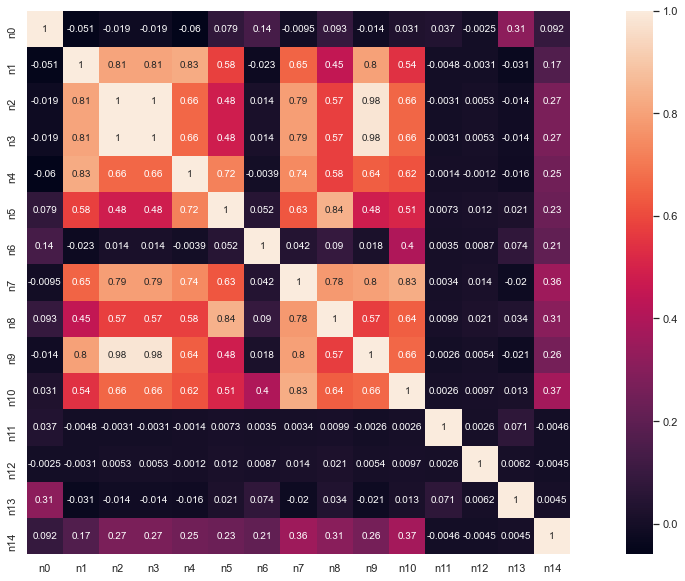

In [104]:
n_features = ['n'+str(i) for i in range(15)]
plt.figure(figsize=(20, 10))
sns.heatmap(data[n_features].corr(), square=True, annot=True)

according to the correlation, remove n2, n3, n4, n8, n9, n10

## 5. Train Model

In [106]:
# split dataset

train = data[data['isDefault']!=-999].drop('isDefault', axis=1)
target = data[data['isDefault']!=-999]['isDefault']
test = data[data['isDefault']==-999].drop('isDefault', axis=1)
x_train, x_val, y_train, y_val = train_test_split(train, target, random_state=2021, test_size=0.2)

In [107]:
def LGB_bayesian(num_leaves, bagging_fraction,feature_fraction, min_child_weight, 
    min_data_in_leaf, max_depth,reg_alpha,reg_lambda):
    
    param = { 'num_leaves': int(num_leaves), 
              'min_data_in_leaf': int(min_data_in_leaf),
              'min_child_weight': min_child_weight,
              'bagging_fraction' : bagging_fraction,
              'feature_fraction' : feature_fraction,
              'max_depth': int(max_depth),
              'reg_alpha': reg_alpha,
              'reg_lambda': reg_lambda,
              'objective': 'binary',
              'save_binary': True,
              'data_random_seed': 1337,
              'boosting_type': 'gbdt',
              'verbose': 1,
              'is_unbalance': False,
              'boost_from_average': True,
              'metric':'auc'}    
    
    trn_data= lgb.Dataset(x_train, label=y_train)
    val_data= lgb.Dataset(x_val, label=y_val)

    lgbm=lgb.train(param, trn_data,num_boost_round=300, 
                    valid_sets = [trn_data, val_data], verbose_eval=50, early_stopping_rounds = 200)
    
    pred_val  = lgbm.predict(x_val, num_iteration=lgbm.best_iteration) 
    score = roc_auc_score(y_val, pred_val)
    return score

bounds_LGB = {
    'num_leaves': (31, 500), 
    'min_data_in_leaf': (20, 200),
    'bagging_fraction' : (0.1, 0.9),
    'feature_fraction' : (0.1, 0.9),
    'min_child_weight': (0.00001, 0.01),   
    'reg_alpha': (1, 2), 
    'reg_lambda': (1, 2),
    'max_depth':(-1,50),}
lgb_op =BayesianOptimization(LGB_bayesian,bounds_LGB)
lgb_op.maximize(init_points=10, n_iter=10, acq='ucb', xi=0.0, alpha=1e-6)
print(lgb_op.max)

|   iter    |  target   | baggin... | featur... | max_depth | min_ch... | min_da... | num_le... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------------------
[LightGBM] [Info] Number of positive: 127696, number of negative: 512304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1414
[LightGBM] [Info] Number of data points in the train set: 640000, number of used features: 151
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199525 -> initscore=-1.389266
[LightGBM] [Info] Start training from score -1.389266
Training until validation scores don't improve for 200 rounds
[50]	training's auc: 0.751671	valid_1's auc: 0.724841
[100]	training's auc: 0.775032	valid_1's auc: 0.726532
[LightGBM] [Warning]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199525 -> initscore=-1.389266
[LightGBM] [Info] Start training from score -1.389266
Training until validation scores don't improve for 200 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	training's auc: 0.838638	valid_1's auc: 0.723531
Did not meet early stopping. Best iteration is:
[300]	training's auc: 0.838638	valid_1's auc: 0.723531
|  7        |  0.7235   |  0.3459   |  0.8998   |  14.0     |  0.000812 |  155.4    |  484.0    |  1.831    |  1.193    |
[LightGBM] [Info] Number of positive: 127696, number of negative: 512304
[LightGBM] [Warning] Auto-choosing row-wise mul

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's auc: 0.745844	valid_1's auc: 0.724626
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[200]	training's auc: 0.760138	valid_1's auc: 0.726369
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199525 -> initscore=-1.389266
[LightGBM] [Info] Start training from score -1.389266
Training until validation scores don't improve for 200 rounds
[50]	training's auc: 0.721471	valid_1's auc: 0.719598
[100]	training's auc: 0.728327	valid_1's auc: 0.724196
[150]	training's auc: 0.732126	valid_1's auc: 0.725615
[200]	training's auc: 0.735291	valid_1's auc: 0.726319
[250]	training's auc: 0.737923	valid_1's auc: 0.72666
[300]	training's auc: 0.740289	valid_1's auc: 0.726833
Did not meet early stopping. Best iteration is:
[300]	training's auc: 0.740289	valid_1's auc: 0.726833
|  9        |  0.7268   |  0.1323   |  0.335    |  16.2     |  0.004252 |  86.63    |  34.04    |  1.608    |  1.552    |
[LightGBM] [Info] Number of positive: 127696, number of negative: 512304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021548 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199525 -> initscore=-1.389266
[LightGBM] [Info] Start training from score -1.389266
Training until validation scores don't improve for 200 rounds
[50]	training's auc: 0.727176	valid_1's auc: 0.722225
[100]	training's auc: 0.735944	valid_1's auc: 0.726007
[150]	training's auc: 0.741425	valid_1's auc: 0.726594
[200]	training's auc: 0.746013	valid_1's auc: 0.726903
[250]	training's auc: 0.750576	valid_1's auc: 0.726992
[300]	training's auc: 0.754609	valid_1's auc: 0.726967
Did not meet early stopping. Best iteration is:
[300]	training's auc: 0.754609	valid_1's auc: 0.726967
|  15       |  0.727    |  0.2535   |  0.7783   |  49.94    |  0.006506 |  176.2    |  57.56    |  1.31     |  1.555    |
[LightGBM] [Info] Number of positive: 127696, number of negative: 512304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memor

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	training's auc: 0.779752	valid_1's auc: 0.726395
Did not meet early stopping. Best iteration is:
[300]	training's auc: 0.779752	valid_1's auc: 0.726395
|  17       |  0.7264   |  0.1009   |  0.2567   |  9.599    |  0.005551 |  41.36    |  397.5    |  1.629    |  1.786    |
[LightGBM] [Info] Number of positive: 127696, number of negative: 512304
[LightGBM] [Warning] Auto-choosing row-wise mul

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[150]	training's auc: 0.799662	valid_1's auc: 0.725084
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

In [108]:
lgb_best = lgb.LGBMClassifier(random_state=2021,learning_rate=0.1 ,
             n_estimators=300 ,bagging_fraction=0.89,feature_fraction=0.35,
             min_child_weight=0.0027,  max_depth= 43,min_data_in_leaf=184,
             num_leaves=48,reg_alpha=1.61,reg_lambda=1.107)
lgb_best.fit(x_train,y_train)
pre_test = lgb_best.predict(test)
proba_test = lgb_best.predict_proba(test)

[LightGBM] [Warning] min_data_in_leaf is set=184, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=184
[LightGBM] [Warning] feature_fraction is set=0.35, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35
[LightGBM] [Warning] bagging_fraction is set=0.89, subsample=1.0 will be ignored. Current value: bagging_fraction=0.89


In [110]:
sub = pd.DataFrame()
testid = pd.read_csv('sample_submit.csv')
sub['id'] = testid['id']
sub['isDefault'] = proba_test[:,1]
sub.to_csv('sub.csv', index=False)

In [111]:
sub

,id,isDefault
0,800000,0.408937
1,800001,0.082756
2,800002,0.024725
3,800003,0.419899
4,800004,0.212401
...,...,...
199995,999995,0.100072
199996,999996,0.197979
199997,999997,0.021576
199998,999998,0.395728


In [114]:
roc_auc_score(y_train, lgb_best.predict_proba(x_train)[:1])

ValueError: Found input variables with inconsistent numbers of samples: [640000, 1]